In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import SGDRegressor, LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import VotingRegressor
import missingno as msn

    VendorName      ModelName  MYCT  MMIN   MMAX  CACH  CHMIN  CHMAX  PRP  ERP
0      adviser          32/60   125   256   6000   256     16    128  198  199
1       amdahl         470v/7    29  8000  32000    32      8     32  269  253
2       amdahl        470v/7a    29  8000  32000    32      8     32  220  253
3       amdahl        470v/7b    29  8000  32000    32      8     32  172  253
4       amdahl        470v/7c    29  8000  16000    32      8     16  132  132
..         ...            ...   ...   ...    ...   ...    ...    ...  ...  ...
204     sperry         Aug-80   124  1000   8000     0      1      8   42   37
205     sperry  90/80-model-3    98  1000   8000    32      2      8   46   50
206     sratus             32   125  2000   8000     0      2     14   52   41
207       wang         vs-100   480   512   8000    32      0      0   67   47
208       wang          vs-90   480  1000   4000     0      0      0   45   25

[209 rows x 10 columns]
<class 'pandas.core.frame.D

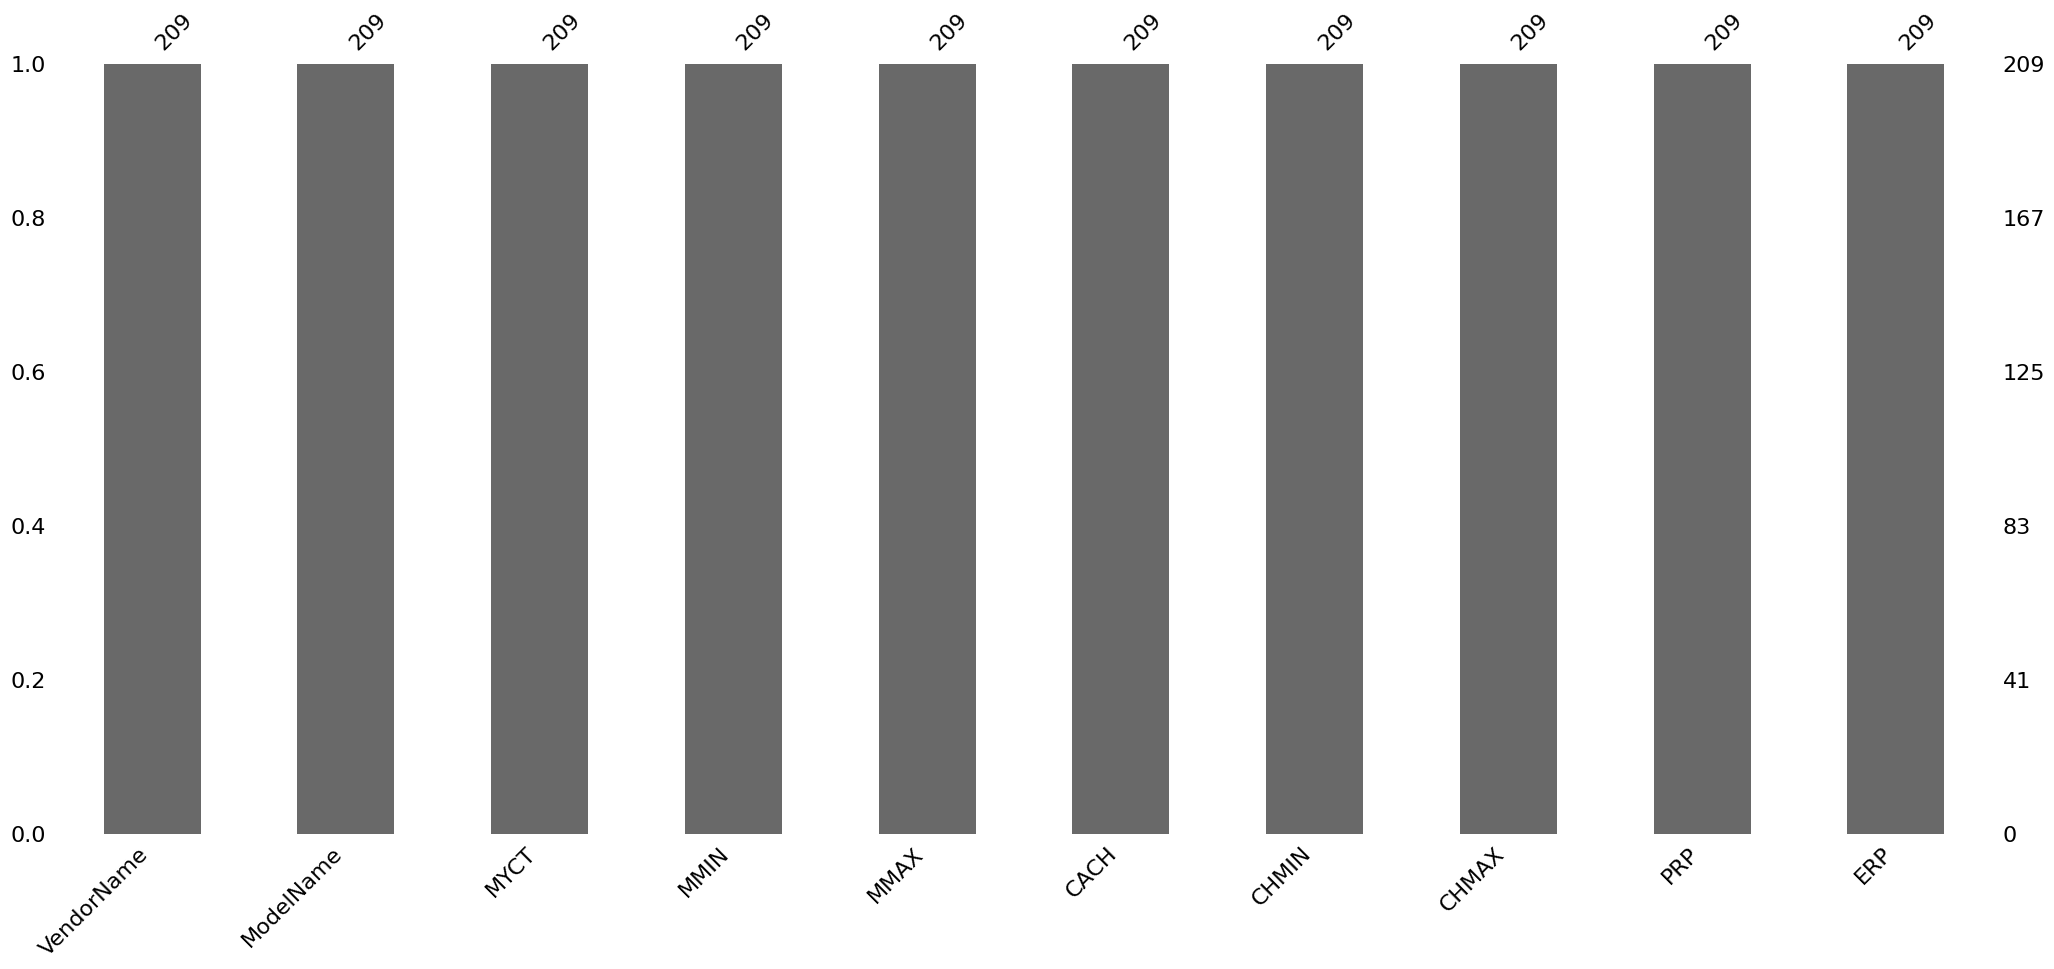

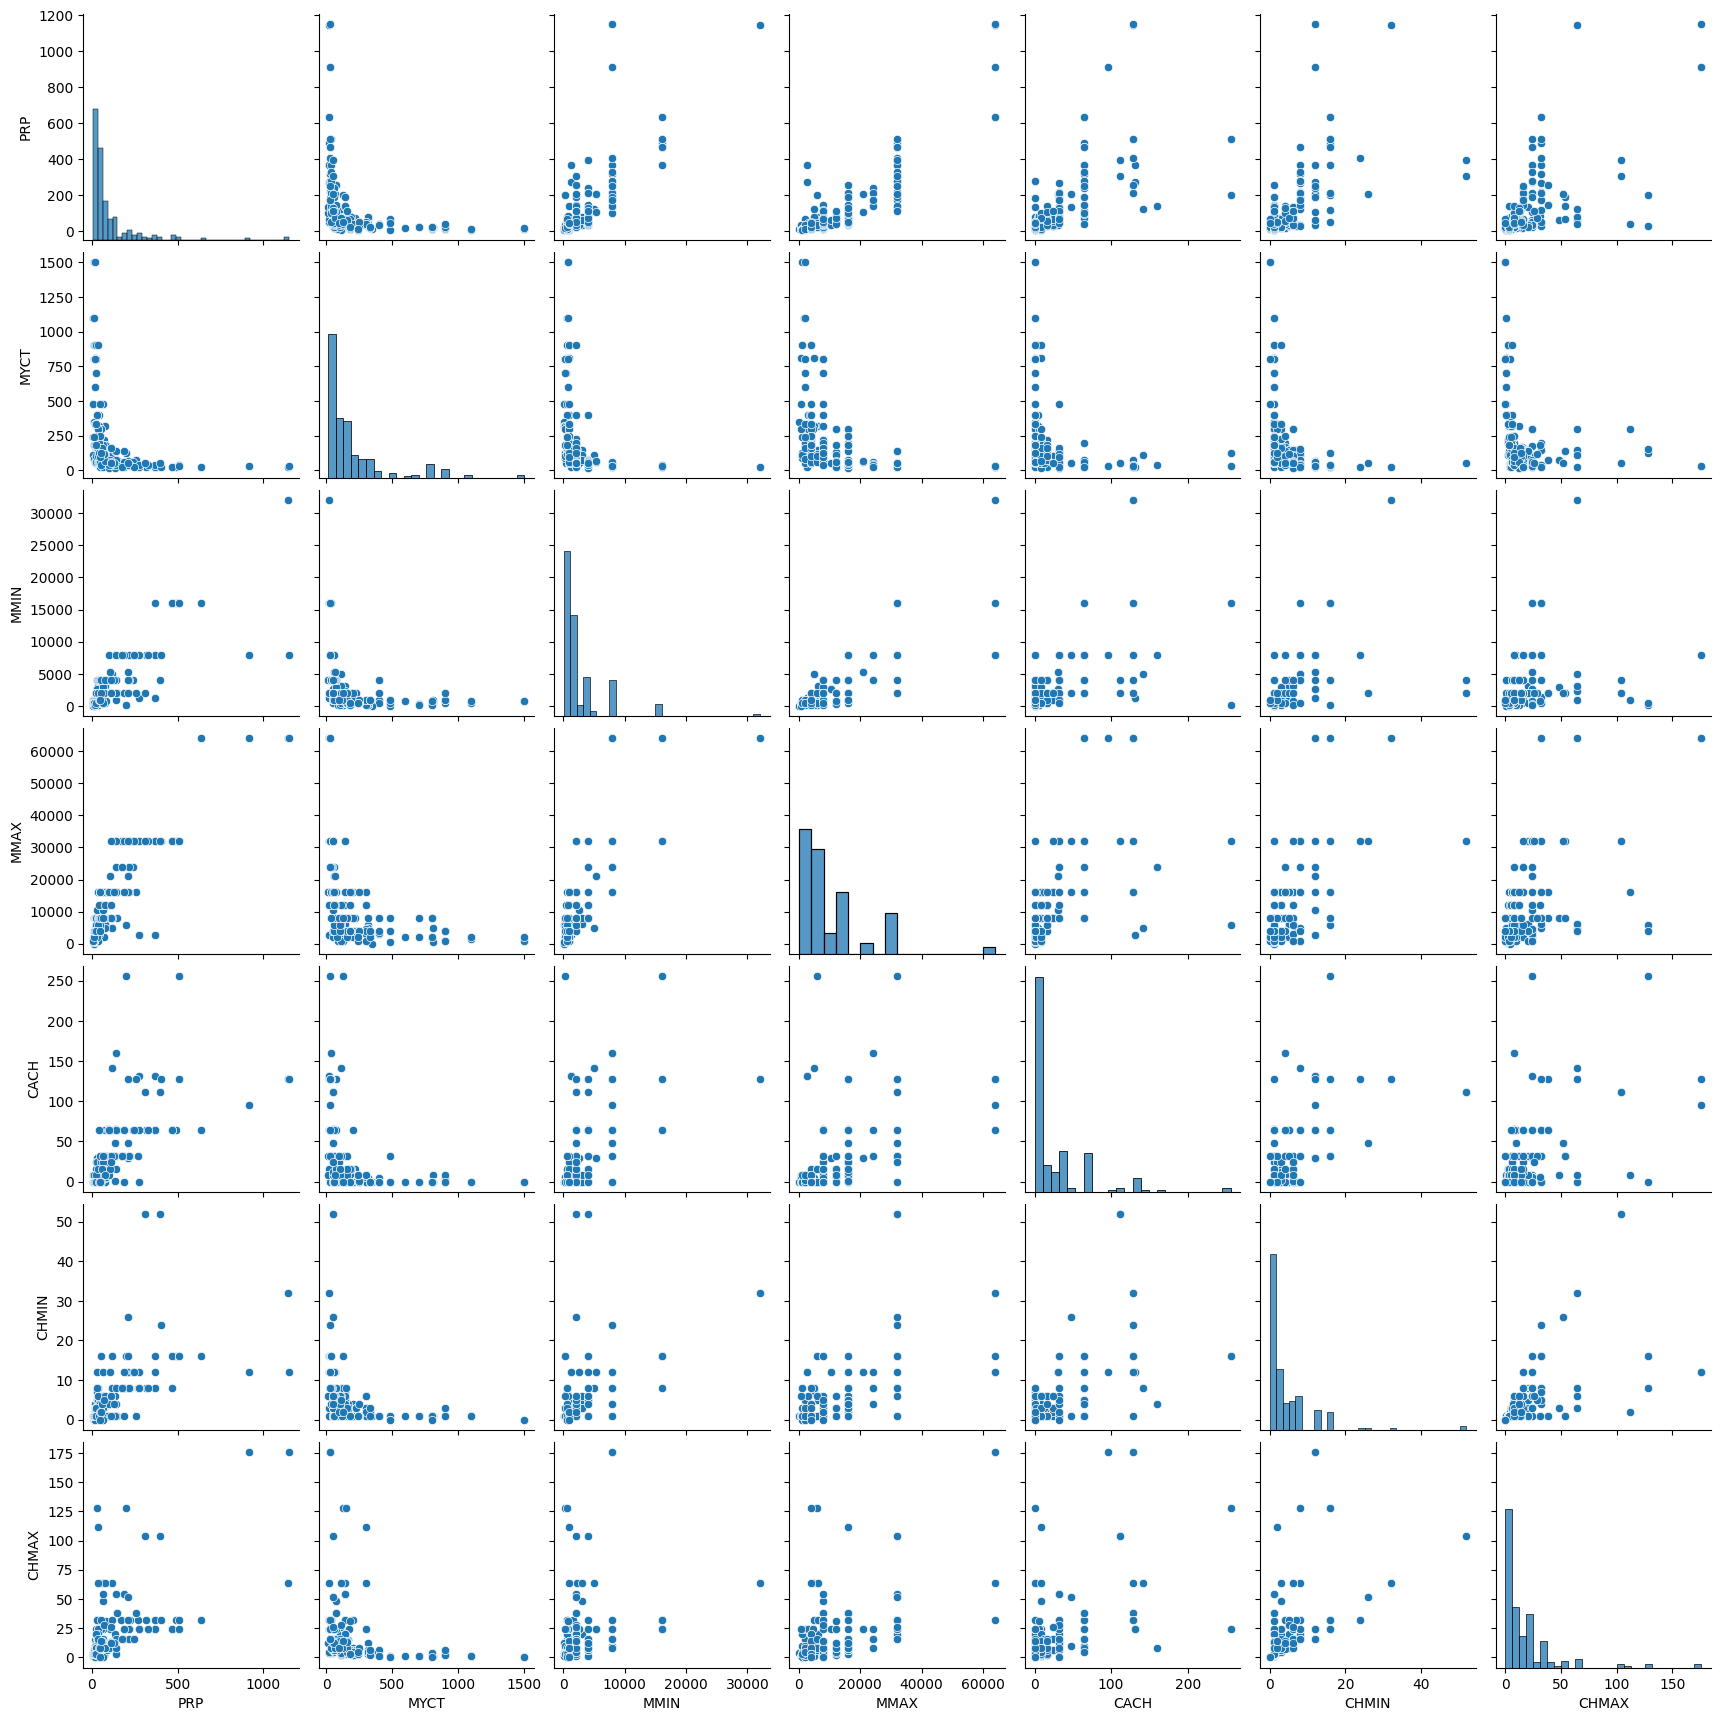

In [2]:
# 데이터 불러오기
data = pd.read_csv('machine.data_update.csv')

# 데이터 탐색 
print(data)
print(data.info())
print(data.describe())

# 결측치 확인
data.isnull().sum()
msn.bar(data)

# 범주형 변수 수치화
dum = pd.get_dummies(data['VendorName'], prefix='vendor_name', dtype=float)
data = pd.concat([data.drop('VendorName', axis=1), dum], axis=1)

dum= pd.get_dummies(data['ModelName'], prefix='model_name', dtype=float)
data = pd.concat([data.drop('ModelName', axis=1), dum], axis=1)

features = ['PRP','MYCT', 'MMIN', 'MMAX', 'CACH', 'CHMIN', 'CHMAX']
# features에 대한 쌍 그래프 그리기
sns.pairplot(data[features])
plt.show()

In [3]:
# features 선택 (ERP는 개선에 이용)
features = ['MYCT', 'MMIN', 'MMAX', 'CACH', 'CHMIN', 'CHMAX']

# 전처리 파이프라인 설정
numeric_transformer = Pipeline(steps = [
    ('scalar', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers = [
        ('num', numeric_transformer, features)

    ]
)
# X와 y 설정
X = data[features]
y = data['PRP']

# X & y 차원 구하기
print(X.shape, y.shape) # (209, 4) (209,)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# 개별 모델 정의
models = [ ('lr', LinearRegression()), ('sgd', SGDRegressor(  )) ]

# 앙상블 모델 정의
ensemble = VotingRegressor(estimators = models)


# 파이프라인 생성
model_pipeline = Pipeline(steps =  [
    ('preprocessor', preprocessor),
    ('ensemble', ensemble)
    ])

# 하이퍼파라미터 튜닝
param_grid = {
    'ensemble__sgd__alpha': [0.0001, 0.1, 1.0, 0.001],
    'ensemble__sgd__max_iter': [1000, 2000, 3000, 4000]
}

# 그리드 서치
grid_search = GridSearchCV(model_pipeline, param_grid,
                           cv = 5, scoring = 'neg_mean_squared_error', return_train_score = True)
grid_search.fit(X_train, y_train)

(209, 6) (209,)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scalar',
                                                                                          StandardScaler())]),
                                                                         ['MYCT',
                                                                          'MMIN',
                                                                          'MMAX',
                                                                          'CACH',
                                                                          'CHMIN',
                                                                          'CHMAX'])])),
                                       ('ensemble',
                                        VotingRegressor(estimators=[('lr',
                                                                     LinearRegression()),
                                                                    ('sgd',
                                                                     SGDRegressor())]))]),
             param_grid={'ensemble__sgd__alpha': [0.0001, 0.1, 1.0, 0.001],
                         'ensemble__sgd__max_iter': [1000, 2000, 3000, 4000]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [4]:
# 최적 파라미터 출력
print(f"Best parameters found : {grid_search.best_params_}")

# 최적 모델로 예측
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

Best parameters found : {'ensemble__sgd__alpha': 1.0, 'ensemble__sgd__max_iter': 2000}


MSE: 7902.642437067764, MAE:47.99091483548938, R^2:0.8447627000246345


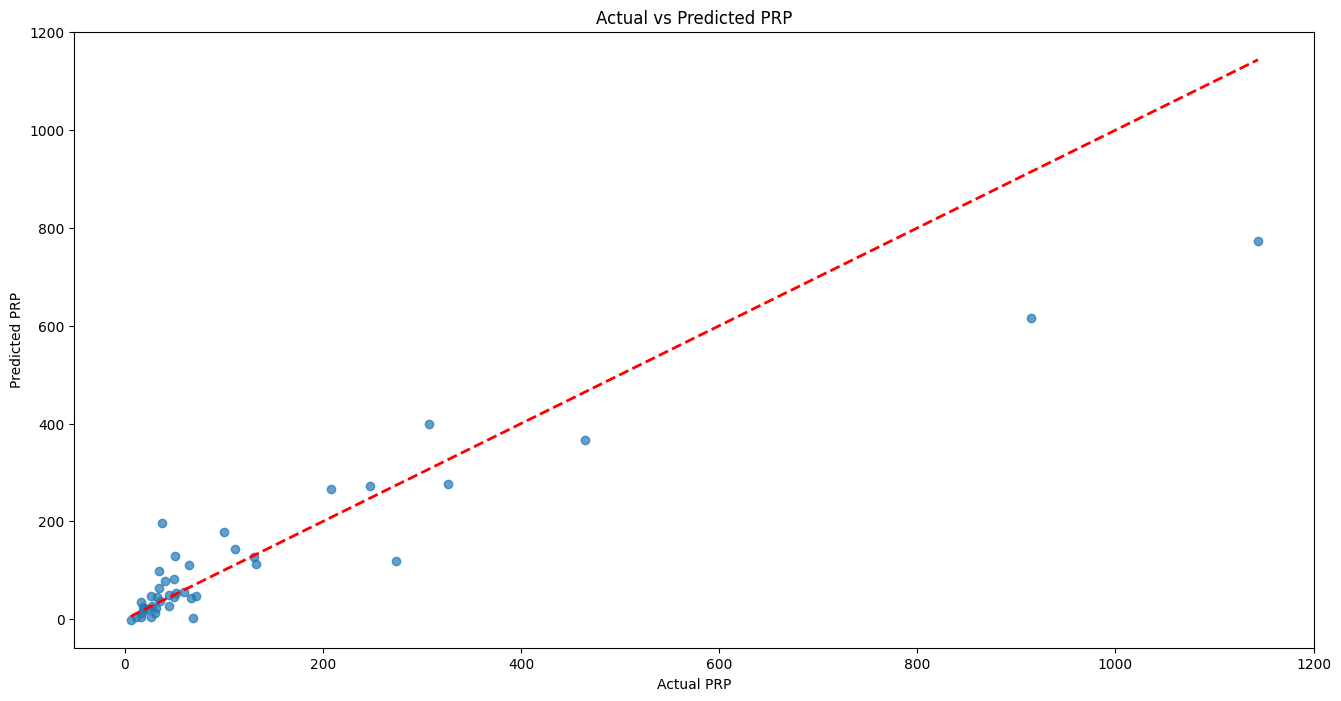

In [5]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse}, MAE:{mae}, R^2:{r2}")
# 시각화
plt.figure(figsize=(16,8))
plt.scatter(y_test, y_pred, alpha=0.7, label="test data")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label = 'Predicted PRP')
plt.xlabel("Actual PRP")
plt.ylabel("Predicted PRP")
plt.title("Actual vs Predicted PRP")
plt.show()

In [6]:
# 교차 검증 예측
cv_scores_mse = -cross_val_score(best_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
cv_scores_mae = -cross_val_score(best_model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
cv_scores_r2 = cross_val_score(best_model, X_train, y_train, cv=5, scoring='r2')
print("교차 검증")
print(f"MSE 평균: {cv_scores_mse.mean()}")
print(f"MAE 평균: {cv_scores_mae.mean()}")
print(f"R^2 평균: {cv_scores_r2.mean()}")

# 훈련 데이터 예측
y_train_pred = best_model.predict(X_train)
print()
print("훈련 데이터")
print(f"MSE: {mean_squared_error(y_train, y_train_pred)}")
print(f"MAE: {mean_absolute_error(y_train, y_train_pred)}")
print(f"R^2: {r2_score(y_train, y_train_pred)}")

# 테스트 데이터 예측
y_test_pred = best_model.predict(X_test)
print()
print("테스트 데이터")
print(f"MSE: {mean_squared_error(y_test, y_test_pred)}")
print(f"MAE: {mean_absolute_error(y_test, y_test_pred)}")
print(f"R^2: {r2_score(y_test, y_test_pred)}")

교차 검증
MSE 평균: 5747.875759358199
MAE 평균: 36.318738395011266
R^2 평균: 0.7318395743085437

훈련 데이터
MSE: 3458.5793532021935
MAE: 31.297497725564945
R^2: 0.8200947661491765

테스트 데이터
MSE: 7902.642437067764
MAE: 47.99091483548938
R^2: 0.8447627000246345


    VendorName      ModelName  MYCT  MMIN   MMAX  CACH  CHMIN  CHMAX  PRP  ERP
0      adviser          32/60   125   256   6000   256     16    128  198  199
1       amdahl         470v/7    29  8000  32000    32      8     32  269  253
2       amdahl        470v/7a    29  8000  32000    32      8     32  220  253
3       amdahl        470v/7b    29  8000  32000    32      8     32  172  253
4       amdahl        470v/7c    29  8000  16000    32      8     16  132  132
..         ...            ...   ...   ...    ...   ...    ...    ...  ...  ...
204     sperry         Aug-80   124  1000   8000     0      1      8   42   37
205     sperry  90/80-model-3    98  1000   8000    32      2      8   46   50
206     sratus             32   125  2000   8000     0      2     14   52   41
207       wang         vs-100   480   512   8000    32      0      0   67   47
208       wang          vs-90   480  1000   4000     0      0      0   45   25

[209 rows x 10 columns]
<class 'pandas.core.frame.D

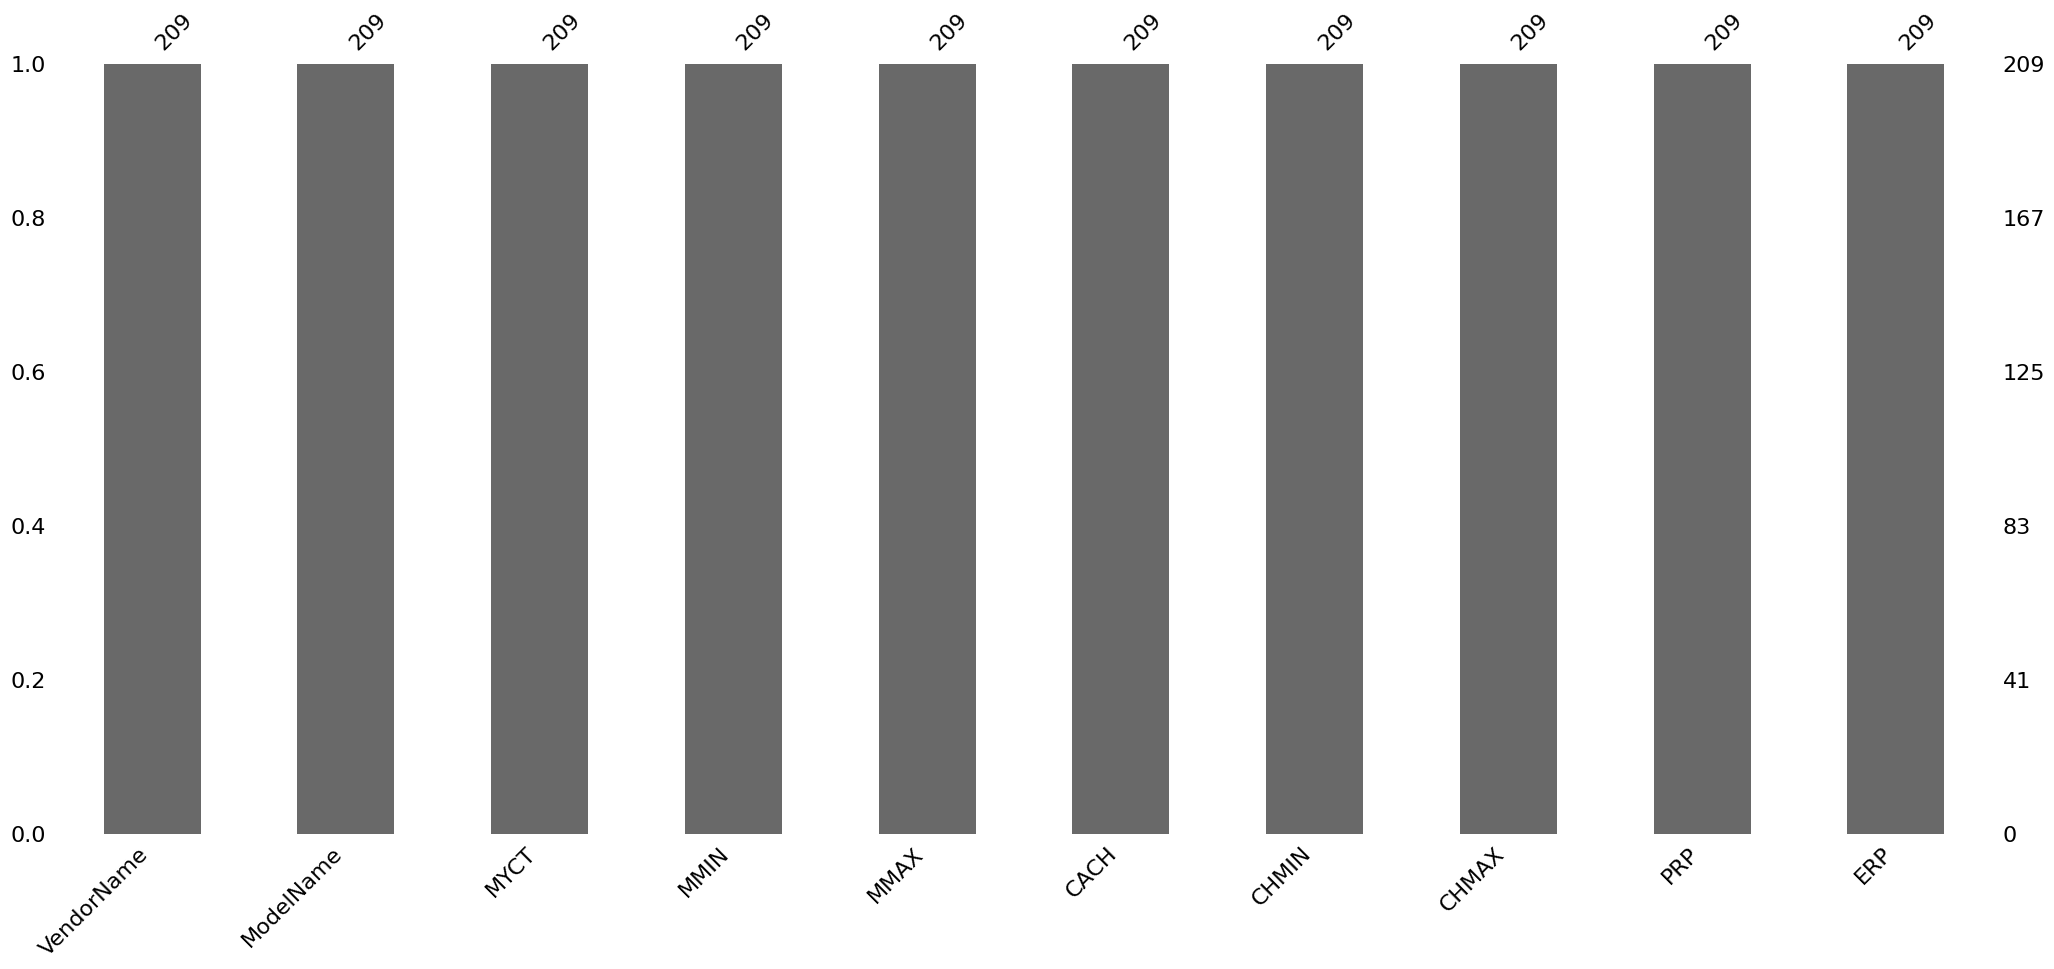

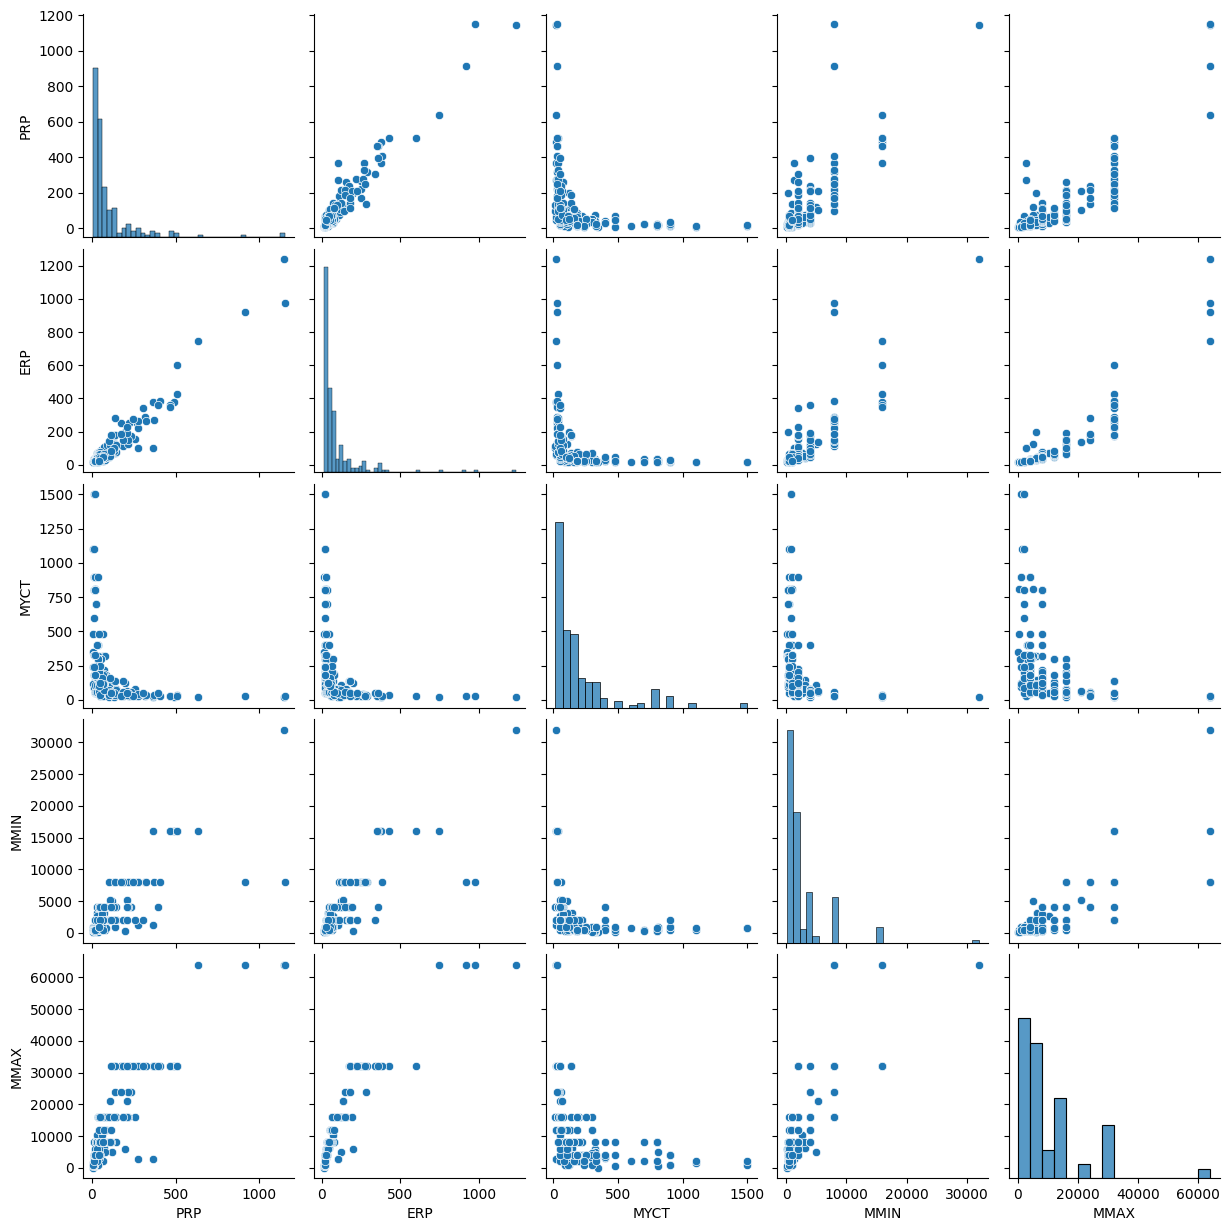

(209, 4) (209,)
Best parameters found : {'ensemble__sgd__alpha': 0.001, 'ensemble__sgd__max_iter': 3000}
MSE: 2174.547036387388, MAE:28.995088995461227, R^2:0.9572838056021847


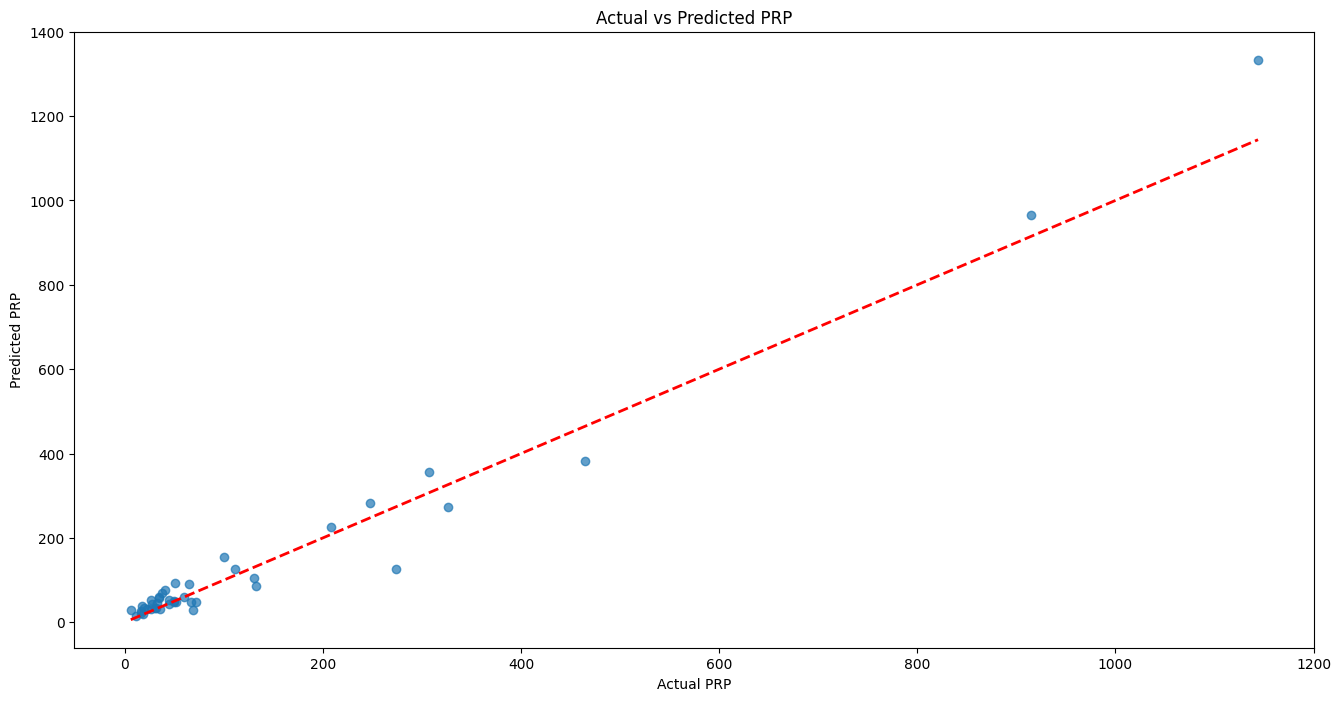

In [7]:
# 데이터 불러오기
data = pd.read_csv('machine.data_update.csv')

# 데이터 탐색 
print(data)
print(data.info())
print(data.describe())

# 결측치 확인
data.isnull().sum()
msn.bar(data)

# 범주형 변수 수치화
dum = pd.get_dummies(data['VendorName'], prefix='vendor_name', dtype=float)
data = pd.concat([data.drop('VendorName', axis=1), dum], axis=1)

dum= pd.get_dummies(data['ModelName'], prefix='model_name', dtype=float)
data = pd.concat([data.drop('ModelName', axis=1), dum], axis=1)

# 상관계수 계산
result = data.corr()['PRP']

# 상관계수 값을 양의 상관계수로 처리
result = np.abs(result)

# 상관계수를 내림차순으로 정렬하기
print(result.sort_values(ascending = False))
# features 선택 (상위 4개)
features = ['PRP', 'ERP', 'MYCT', 'MMIN', 'MMAX']
# features에 대한 쌍 그래프 그리기
sns.pairplot(data[features])
plt.show()
# features 선택 
features = ['ERP', 'MYCT', 'MMIN', 'MMAX']

# 전처리 파이프라인 설정
numeric_transformer = Pipeline(steps = [
    ('scalar', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers = [
        ('num', numeric_transformer, features)

    ]
)
# X와 y 설정
X = data[features]
y = data['PRP']

# X & y 차원 구하기
print(X.shape, y.shape) # (209, 4) (209,)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# 개별 모델 정의
models = [ ('lr', LinearRegression()), ('sgd', SGDRegressor(  )) ]

# 앙상블 모델 정의
ensemble = VotingRegressor(estimators = models)


# 파이프라인 생성
model_pipeline = Pipeline(steps =  [
    ('preprocessor', preprocessor),
    ('ensemble', ensemble)
    ])

# 하이퍼파라미터 튜닝
param_grid = {
    'ensemble__sgd__alpha': [0.0001, 0.1, 1.0, 0.001],
    'ensemble__sgd__max_iter': [1000, 2000, 3000, 4000]
}

# 그리드 서치
grid_search = GridSearchCV(model_pipeline, param_grid,
                           cv = 5, scoring = 'neg_mean_squared_error', return_train_score = True)
grid_search.fit(X_train, y_train)
# 최적 파라미터 출력
print(f"Best parameters found : {grid_search.best_params_}")

# 최적 모델로 예측
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse}, MAE:{mae}, R^2:{r2}")
# 시각화
plt.figure(figsize=(16,8))
plt.scatter(y_test, y_pred, alpha=0.7, label="test data")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label = 'Predicted PRP')
plt.xlabel("Actual PRP")
plt.ylabel("Predicted PRP")
plt.title("Actual vs Predicted PRP")
plt.show()

In [8]:
# 교차 검증 예측
cv_scores_mse = -cross_val_score(best_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
cv_scores_mae = -cross_val_score(best_model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
cv_scores_r2 = cross_val_score(best_model, X_train, y_train, cv=5, scoring='r2')
print("교차 검증")
print(f"MSE 평균: {cv_scores_mse.mean()}")
print(f"MAE 평균: {cv_scores_mae.mean()}")
print(f"R^2 평균: {cv_scores_r2.mean()}")

# 훈련 데이터 예측
y_train_pred = best_model.predict(X_train)
print()
print("훈련 데이터")
print(f"MSE: {mean_squared_error(y_train, y_train_pred)}")
print(f"MAE: {mean_absolute_error(y_train, y_train_pred)}")
print(f"R^2: {r2_score(y_train, y_train_pred)}")

# 테스트 데이터 예측
y_test_pred = best_model.predict(X_test)
print()
print("테스트 데이터")
print(f"MSE: {mean_squared_error(y_test, y_test_pred)}")
print(f"MAE: {mean_absolute_error(y_test, y_test_pred)}")
print(f"R^2: {r2_score(y_test, y_test_pred)}")

교차 검증
MSE 평균: 2090.7310080101556
MAE 평균: 25.712225885981923
R^2 평균: 0.8752469933500203

훈련 데이터
MSE: 1601.2045054775979
MAE: 23.639446009197247
R^2: 0.9167100009620341

테스트 데이터
MSE: 2174.547036387388
MAE: 28.995088995461227
R^2: 0.9572838056021847


In [9]:
# 성능 지표 저장
performance = {
    'model': ['Best_estimator', 'Best_estimator', 'Best_estimator'],
    'data': ['Cross Validation','Train', 'Test'],
    'mse': [2099.3543159356686, 1603.5481174609415, 2122.8027925063157],
    'mae': [25.719351597135166, 23.64885662498082, 28.780942023652386],
    'R^2': [0.8742054951993993, 0.9165880930863254, 0.9583002550712493]
}

# 데이터프레임 생성
Best_estimator_Result = pd.DataFrame(performance)

# 데이터프레임을 CSV 파일로 저장
Best_estimator_Result.to_csv('Best_estimator_Result.csv', index=False)

Best_estimator_Result

,model,data,mse,mae,R^2
0,Best_estimator,Cross Validation,2099.354316,25.719352,0.874205
1,Best_estimator,Train,1603.548117,23.648857,0.916588
2,Best_estimator,Test,2122.802793,28.780942,0.958300


In [10]:
#3차, 4차 프로그래밍 결과 csv 파일 합치기
Linear_Regression_Result = pd.read_csv('Linear_Regression_Result.csv')
Best_estimator_Result = pd.read_csv('Best_estimator_Result.csv')

# 두 데이터프레임 병합
result = pd.concat([Linear_Regression_Result, Best_estimator_Result], ignore_index=True)

result = result.sort_values('R^2',ascending = False, ignore_index=True)
result

,model,data,mse,mae,R^2
0,Best_estimator,Test,2122.802793,28.780942,0.958300
1,Linear Regression,Test,2294.003460,29.507229,0.954937
2,Linear Regression,Train,1599.019320,23.673727,0.916824
3,Best_estimator,Train,1603.548117,23.648857,0.916588
4,Linear Regression,Cross Validation,2032.776230,25.660890,0.875901
5,Best_estimator,Cross Validation,2099.354316,25.719352,0.874205


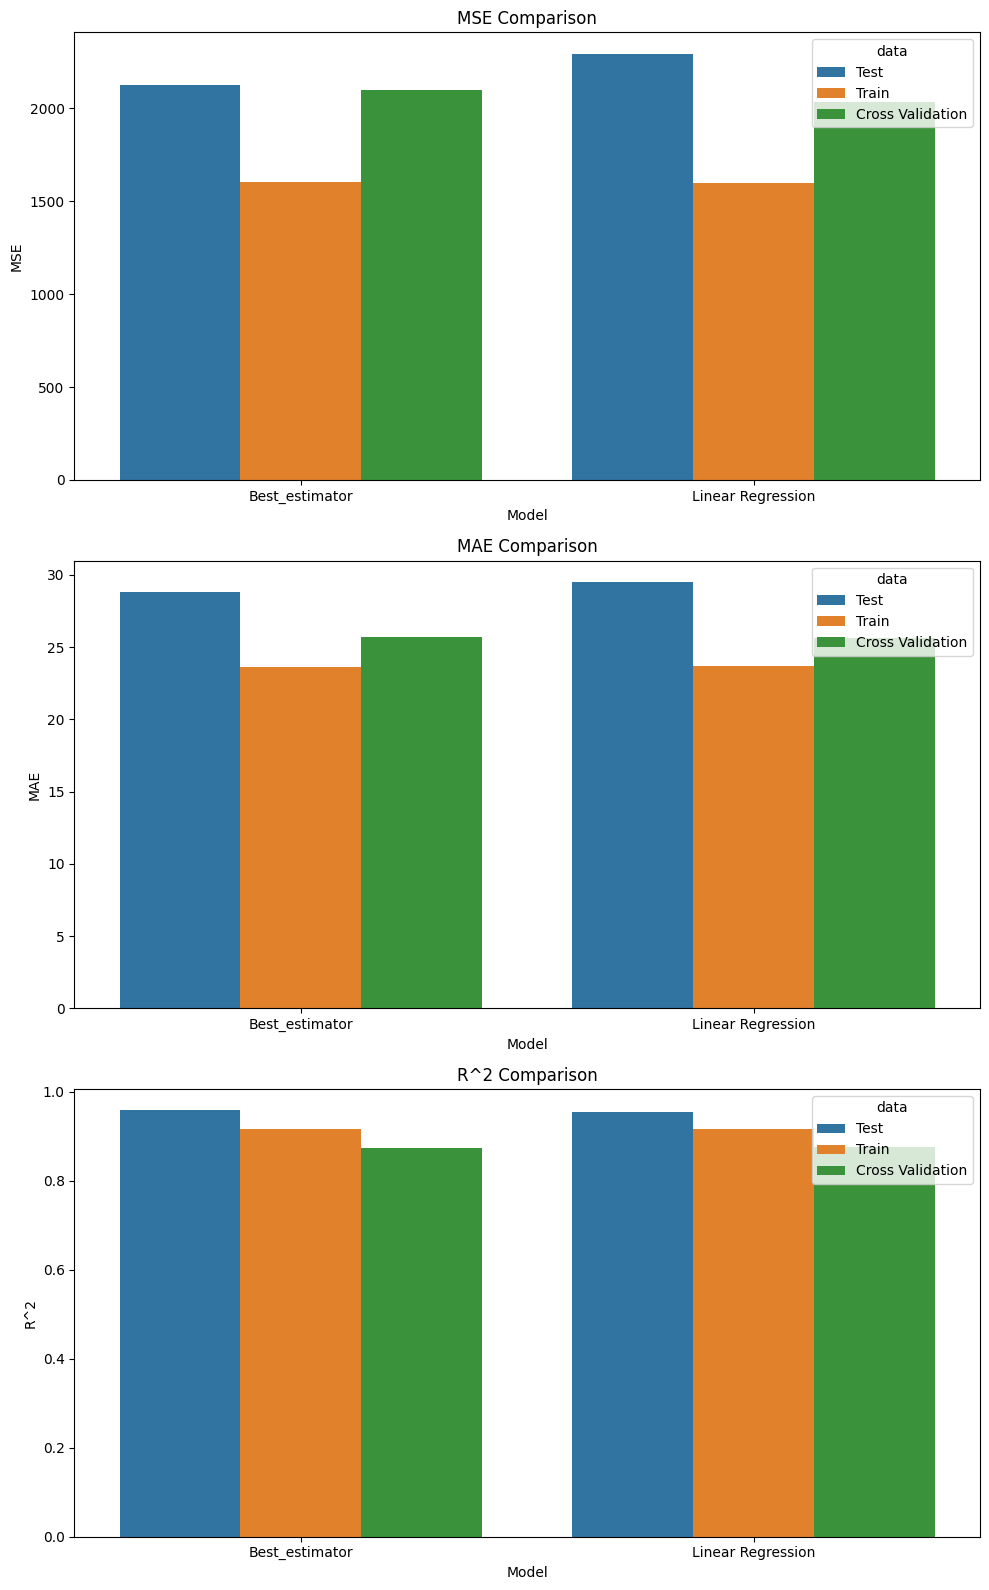

In [11]:
plt.figure(figsize=(10, 16))

# MSE 비교
plt.subplot(3, 1, 1)
sns.barplot(x='model', y='mse', hue='data', data=result)
plt.title('MSE Comparison')
plt.ylabel('MSE')
plt.xlabel('Model')

# MAE 비교
plt.subplot(3, 1, 2)
sns.barplot(x='model', y='mae', hue='data', data=result)
plt.title('MAE Comparison')
plt.ylabel('MAE')
plt.xlabel('Model')

# R^2 비교
plt.subplot(3, 1, 3)
sns.barplot(x='model', y='R^2', hue='data', data=result)
plt.title('R^2 Comparison')
plt.ylabel('R^2')
plt.xlabel('Model')

# 시각화
plt.tight_layout()
plt.show()